# Import necessary modules

In [ ]:
import keras
import numpy as np
import tensorflow as tf
import matplotlib as mpl
from PIL import Image
import matplotlib.pyplot as plt

# Load pretrained MobileNetV2 model

In [ ]:
model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Helper function to preprocess image

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Load image

In [ ]:
image_path = tf.keras.utils.get_file('sanda-1.jpg', 'https://tfe-bd.sgp1.cdn.digitaloceanspaces.com/posts/97974/sanda.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


# Calculate signed gradient

In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 41
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)

# Create the adversarial image

In [ ]:
epsilon = 0.01
description = f"Epsilon = {epsilon:.2f}"

# Generate adversarial image
adv_x = image + epsilon * perturbations
adv_x = tf.clip_by_value(adv_x, -1, 1)

# Predict label
pred = model(adv_x)
label = get_imagenet_label(pred)

# Plot the images (Original, Noise, Adversarial)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


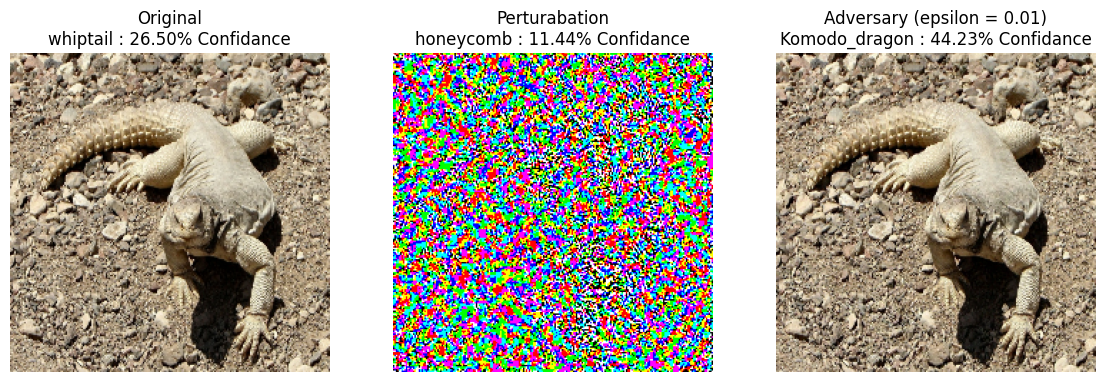

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidance = get_imagenet_label(image_probs)
plt.title('Original\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(perturbations[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(perturbations))
plt.title('Perturabation\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.01)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.show()
plt.close()

# Grad-CAM Heatmap

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(model.inputs, [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Remove softmax

In [ ]:
model.layers[-1].activation = None

In [ ]:
model.layers[-1].activation

# Create superimposed image for Grad-CAM

In [ ]:
def save_and_display_gradcam(img_tensor, heatmap, alpha=0.4):
    img = img_tensor[0].numpy()                 # shape: (224, 224, 3), range [-1, 1]
    img = (img + 1.0) / 2.0                      # scale to [0, 1]
    img = np.uint8(255 * img)                   # scale to [0, 255]

    # Rescale heatmap to [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]     # shape: (256, 3)
    jet_heatmap = jet_colors[heatmap]           # shape: (H, W, 3), still float32 in [0, 1]

    # Resize heatmap directly using PIL (more accurate resizing)
    heatmap_img = Image.fromarray(np.uint8(jet_heatmap * 255))
    heatmap_img = heatmap_img.resize((img.shape[1], img.shape[0]), resample=Image.BILINEAR)
    jet_heatmap = np.array(heatmap_img)         # shape: (H, W, 3), dtype: uint8

    # Superimpose
    superimposed_img = jet_heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.uint8(superimposed_img)

    return superimposed_img

# Integrated Gradients

In [ ]:
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

In [ ]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [ ]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)[:, target_class_idx]
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(logits, images)

In [ ]:
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Collect gradients.
  gradient_batches = []

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    gradient_batch = one_batch(baseline, image, alpha_batch, target_class_idx)
    gradient_batches.append(gradient_batch)

  # Concatenate path gradients together row-wise into single tensor.
  total_gradients = tf.concat(gradient_batches, axis=0)

  # Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [ ]:
@tf.function
def one_batch(baseline, image, alpha_batch, target_class_idx):
    # Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    return gradient_batch

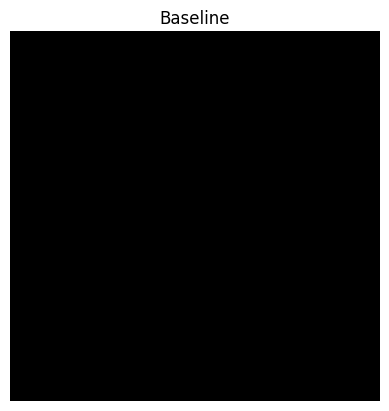

In [ ]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [ ]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=adv_x[0],
                                       target_class_idx=48,
                                       m_steps=240)

In [ ]:
print(ig_attributions.shape)

(224, 224, 3)


In [ ]:
def generate_attribution_mask(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)
  return attribution_mask

# Plot both the Grad-CAM and IG images for Original image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


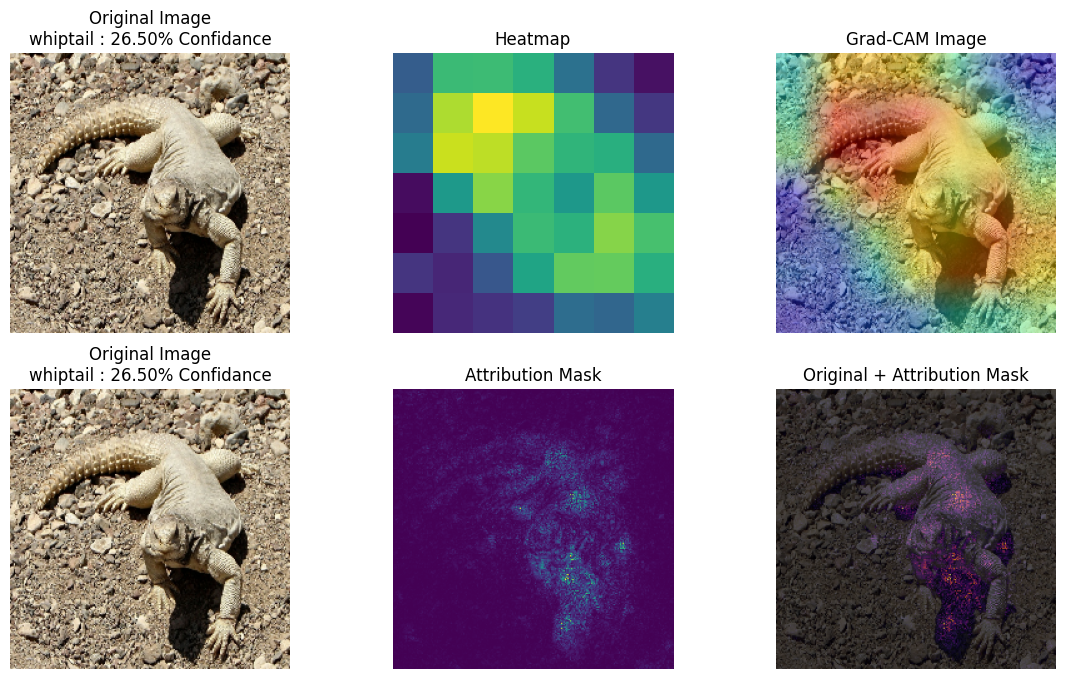

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap_original = make_gradcam_heatmap(img_array=image, model=model, last_conv_layer_name='Conv_1', pred_index=41)
plt.imshow(heatmap_original * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(image, heatmap_original))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(image=image[0], baseline=baseline, target_class_idx=41, m_steps=240,)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(image[0] * 0.5 + 0.5, alpha=0.3, cmap=plt.cm.inferno)
plt.title("Original + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()

# Plot both the Grad-CAM and IG images for Adversarial image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


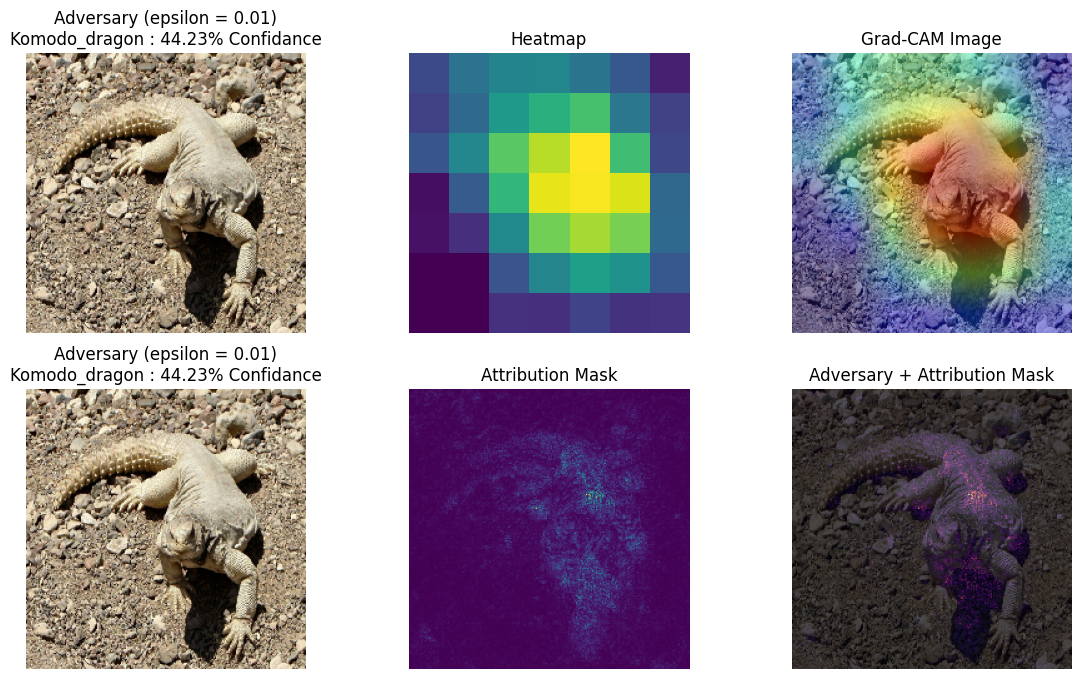

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.01)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap = make_gradcam_heatmap(img_array=adv_x, model=model, last_conv_layer_name='Conv_1', pred_index=48)
plt.imshow(heatmap * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(adv_x, heatmap))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(adv_x[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(model.predict(adv_x))
plt.title('Adversary (epsilon = 0.01)\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(image=adv_x[0], baseline=baseline, target_class_idx=48, m_steps=240,)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(adv_x[0] * 0.5 + 0.5, alpha=0.3, cmap=plt.cm.inferno)
plt.title("Adversary + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()

# Investigate what will happen if you consider softmax layer for Grad-CAM and the previous-layer of the softmax layer for IG for estimating gradients.

In [ ]:
base_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
base_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [ ]:
base_model.layers[-1].activation

<function keras.src.activations.activations.softmax(x, axis=-1)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


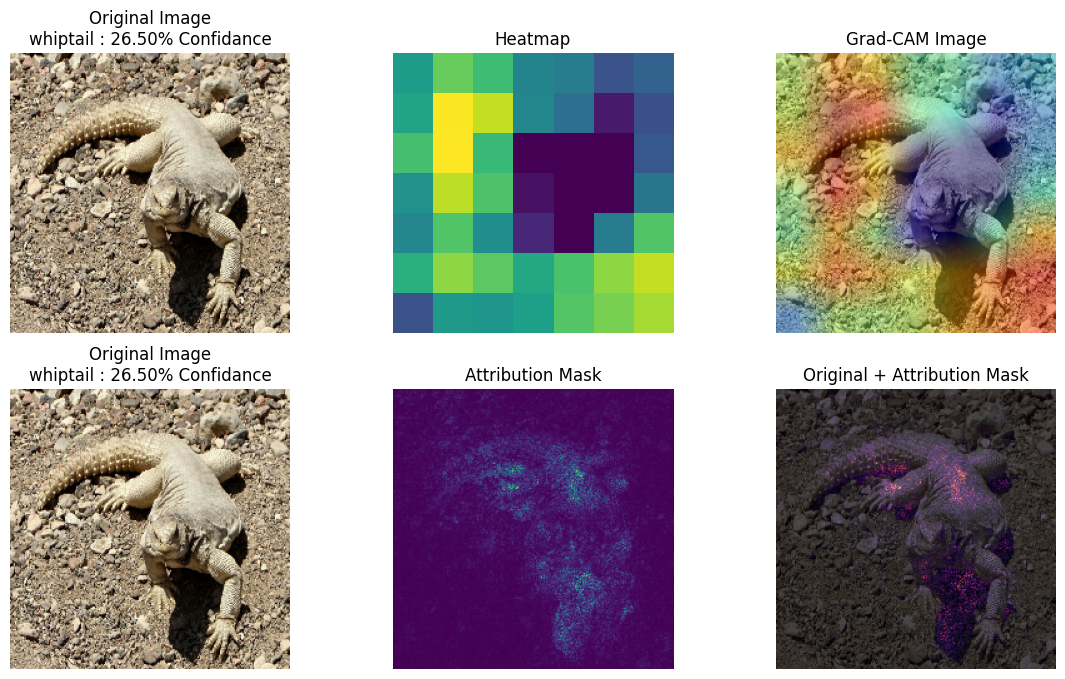

In [ ]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(base_model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 2)
heatmap_original = make_gradcam_heatmap(img_array=image, model=base_model, last_conv_layer_name='Conv_1', pred_index=41)
plt.imshow(heatmap_original * 0.5 + 0.5)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(save_and_display_gradcam(image, heatmap_original))
plt.title("Grad-CAM Image")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(image[0] * 0.5 + 0.5)
_, image_class, class_confidance = get_imagenet_label(base_model.predict(image))
plt.title('Original Image\n{} : {:.2f}% Confidance'.format(image_class, class_confidance*100))
plt.axis('off')

plt.subplot(2, 3, 5)
attribution_mask = generate_attribution_mask(image=image[0], baseline=baseline, target_class_idx=41, m_steps=240,)
plt.imshow(attribution_mask * 0.5 + 0.5)
plt.title('Attribution Mask')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(attribution_mask * 0.5 + 0.5, cmap=plt.cm.inferno)
plt.imshow(image[0] * 0.5 + 0.5, alpha=0.3, cmap=plt.cm.inferno)
plt.title("Original + Attribution Mask")
plt.axis('off')

plt.show()
plt.close()